<a href="https://colab.research.google.com/github/FlagArihant2000/Chua-s-Circuit/blob/master/ResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/SemSeg'

/content/drive/My Drive/SemSeg


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy import ndimage
#from dataloader import *
#from utils import *
#from models.unet import *
from torchvision import models
from torchsummary import summary
from sklearn.cluster import KMeans

In [ ]:
#dataset = torchvision.datasets.Cityscapes('/cityscapes/', split = 'train', mode = 'fine',
#                                          target_type = 'semantic')

In [4]:
def c2g(colors, grayscale):
  c2g = []
  for color in colors:
    color = np.reshape(color, (1,1,3))
    if grayscale:
      gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
    else:
      gray = color
    c2g.append(gray)
  return c2g
# Pixel classes
colors = np.array([[0,0,0], [111,74,0], [81,0,81], [128,64,128], [244, 35, 232]
                   ,[250, 170, 160], [230, 150, 140], [70,70,70], [102,102, 156]
                   , [190, 153, 153], [180, 165, 180], [150, 100, 100]
                   , [150, 120, 90], [153, 153, 153], [250, 170, 30], [220, 220, 0]
                   , [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60]
                   , [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90]
                   , [0, 0, 110], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 142]], dtype = np.uint8)

In [5]:
label_model = KMeans(n_clusters = 30)
label_model.fit(colors)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (29) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [6]:
image_corr = cv2.imread('/content/drive/My Drive/SemSeg/CamVid/train/0001TP_009210.png')
label_corr = cv2.imread('/content/drive/My Drive/SemSeg/CamVid/train_labels/0001TP_009210_L.png')

In [7]:
label_cls = label_model.predict(label_corr.reshape(-1,3)).reshape(720,960)

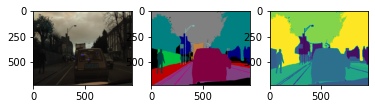

In [8]:
plt.subplot(131)
plt.imshow(image_corr)
plt.subplot(132)
plt.imshow(label_corr)
plt.subplot(133)
plt.imshow(label_cls)

In [9]:
#colors = c2g(colors, grayscale = True)

In [10]:
# Perform Data Loading

transform_img = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
transform_label = transforms.Compose([transforms.ToTensor()])

In [11]:
os.getcwd()

'/content/drive/My Drive/SemSeg'

In [15]:
def load_img(directory, gray, input):
  images = []
  for img in sorted(os.listdir(directory)):
    img = cv2.imread(os.path.join(directory, img))
    if input:
      img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    else:
      img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    if gray:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)
  return images

def class_pix(labelimg, colors):
  class_pix = np.ones([224,224,1], dtype = int)
  for index, c in enumerate(colors):
    class_pix[labelimg == c] = index
  return class_pix

def label(imagelist, colors):
  images = []
  for img in imagelist:
    images.append(class_pix(img, colors))
  return images

In [16]:
class CamVid(data.Dataset):
  def __init__(self, transform = None, imgdir = None, labeldir = None, transformlabel = None, label_model = None):
    self.label_model = label_model
    self.train_img = load_img(imgdir, gray = False, input = True)
    self.train_label = load_img(labeldir, gray = False, input = True)
    self.transform = transform
    self.transformlabel = transformlabel
  def __len__(self):
    return len(self.train_img)
  def __getitem__(self, index):
    img = self.transform(self.train_img[index])
    label = self.label_model.predict(self.train_label[index].reshape(-1,3)).reshape(224,224)
    label = self.transformlabel(label)
    return img, label

In [17]:
trainset = CamVid(transform = transform_img, imgdir = os.path.join(os.getcwd(),'CamVid/train'),
                 labeldir = os.path.join(os.getcwd(), 'CamVid/train_labels'),
                  transformlabel = transform_label, label_model = label_model)
valset = CamVid(transform = transform_img, imgdir = os.path.join(os.getcwd(),'CamVid/val'),
                 labeldir = os.path.join(os.getcwd(), 'CamVid/val_labels'),
                  transformlabel = transform_label, label_model = label_model)
testset = CamVid(transform = transform_img, imgdir = os.path.join(os.getcwd(),'CamVid/test'),
                 labeldir = os.path.join(os.getcwd(), 'CamVid/test_labels'),
                  transformlabel = transform_label, label_model = label_model)

In [18]:
train_loader = data.DataLoader(trainset, batch_size = 1, shuffle = True, num_workers = 4)
val_loader = data.DataLoader(valset, batch_size = 1, shuffle = True, num_workers = 4)
test_loader = data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 4)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [21]:
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel, padding = padding),
                       nn.ReLU(inplace = True)
  )

class ResUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()
    self.base_model = models.resnet18(pretrained = True)
    self.base_layers = list(base_model.children())
    self.layer0 = nn.Sequential(*self.base_layers[:3])
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5])
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]
    self.layer4_1x1 = convrelu(512, 512, 1, 0)
    self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners= True)
    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)
    #print(layer2.size(), layer1.size(), layer0.size(), input.size())
    layer4 = self.layer4_1x1(layer4)
    
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim = 1)
    x = self.conv_up3(x)
    
    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim = 1)
    x = self.conv_up2(x)
    
    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim = 1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim = 1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim = 1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [ ]:
#base_model = models.resnet18(pretrained = True)
#model = ResUNet(32)
#model = model.to(device)
#summary(model, input_size = (3,224,224))

In [22]:
base_model = models.resnet18(pretrained = True)
UNET = ResUNet(32)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [23]:
#UNET = UNet()
UNET.to(device)

ResUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(UNET.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0, amsgrad = False)

In [25]:
#import os
#os._exit(00)

In [26]:
#UNET = torch.load(os.path.join(os.getcwd(), unet20.pth))

In [27]:
train_loss = []
val_loss = []
epochs = 100
for ep in range(epochs):
  UNET.train()
  running_loss = 0.0
  counter = 0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    if labels.size() == torch.Size([1, 1, 224, 224]):
      labels = labels.reshape(1, 224, 224)
    optimizer.zero_grad()
    outputs = UNET(inputs)
    #print(outputs.dtype, labels.dtype)
    loss = criterion(outputs, labels.long())
    loss.backward()
    optimizer.step()
    running_loss = running_loss + loss.item()
    counter = counter + 1
  epoch_loss = running_loss/counter
  print('Epoch {}/{}, {} Loss: {:.4f}'.format(ep, epochs, 'Training', epoch_loss))
  train_loss = train_loss + [epoch_loss]
  UNET.eval()
  running_loss = 0.0
  counter = 0
  for i, data in enumerate(val_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    if labels.size() == torch.Size([1, 1, 224, 224]):
      labels = labels.reshape(1, 224, 224)
    optimizer.zero_grad()
    outputs = UNET(inputs)
    loss = criterion(outputs, labels.long())
    running_loss = running_loss + loss.item()
    counter = counter + 1
  epoch_loss = running_loss/counter
  print('Epoch {}/{}, {} Loss: {:.4f}'.format(ep, epochs, 'Validation', epoch_loss))
  val_loss = val_loss + [epoch_loss]
  if ep%10 == 0:
    print("Saving Model after epoch {}".format(ep))
    torch.save(UNET.state_dict(), os.path.join(os.getcwd(), 'unet{}.pth'.format(ep)))

Epoch 0/100, Training Loss: 1.2814
Epoch 0/100, Validation Loss: 1.1177
Saving Model after epoch 0
Epoch 1/100, Training Loss: 0.9164
Epoch 1/100, Validation Loss: 0.8033
Epoch 2/100, Training Loss: 0.7639
Epoch 2/100, Validation Loss: 0.9364
Epoch 3/100, Training Loss: 0.6942
Epoch 3/100, Validation Loss: 0.7372
Epoch 4/100, Training Loss: 0.6263
Epoch 4/100, Validation Loss: 0.8027
Epoch 5/100, Training Loss: 0.6178
Epoch 5/100, Validation Loss: 0.8852
Epoch 6/100, Training Loss: 0.5620
Epoch 6/100, Validation Loss: 0.7284
Epoch 7/100, Training Loss: 0.5432
Epoch 7/100, Validation Loss: 0.7473
Epoch 8/100, Training Loss: 0.5398
Epoch 8/100, Validation Loss: 0.6665
Epoch 9/100, Training Loss: 0.4865
Epoch 9/100, Validation Loss: 0.7747
Epoch 10/100, Training Loss: 0.4770
Epoch 10/100, Validation Loss: 0.6921
Saving Model after epoch 10
Epoch 11/100, Training Loss: 0.4495
Epoch 11/100, Validation Loss: 0.6755
Epoch 12/100, Training Loss: 0.4282
Epoch 12/100, Validation Loss: 0.6372
Epo

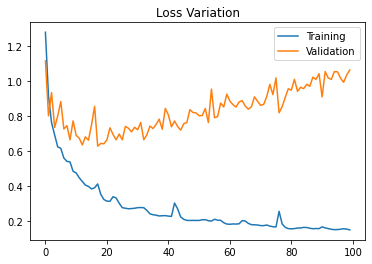

In [28]:
plt.plot(train_loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.title("Loss Variation")
plt.legend()
plt.show()

It turns out that overfitting had started after epoch 20. Therefore, using the weights saved at that point.

In [29]:
%ls

CamVid/        license.txt    unet0.pth   unet50.pth  unet.ipynb
cityscapes/    models/        unet10.pth  unet60.pth  utils.py
Copy.ipynb     __pycache__/   unet20.pth  unet70.pth  VanillaUNet.pth
dataloader.py  README         unet30.pth  unet80.pth
gtFine/        ResUNet.ipynb  unet40.pth  unet90.pth


In [ ]:
colors = np.array([[0,0,0], [111,74,0], [81,0,81], [128,64,128], [244, 35, 232]
                   ,[250, 170, 160], [230, 150, 140], [70,70,70], [102,102, 156]
                   , [190, 153, 153], [180, 165, 180], [150, 100, 100]
                   , [150, 120, 90], [153, 153, 153], [250, 170, 30], [220, 220, 0]
                   , [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60]
                   , [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90]
                   , [0, 0, 110], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 142]], dtype = np.uint8)
colors = c2g(colors, grayscale = False)

In [ ]:
def testing(image, colors):
  class_pix = np.ones([224,224,3], dtype = np.uint8)
  for index, c in enumerate(colors):
    class_pix[image == index] = c
  return class_pix.reshape((224,224,3))

In [ ]:
inputs, labels = next(iter(test_loader))

In [ ]:
inputs, labels = inputs.to(device), labels.to(device)

In [30]:
UNET = ResUNet(32)

In [31]:
UNET.load_state_dict(torch.load(os.path.join(os.getcwd(), 'unet20.pth')))

<All keys matched successfully>

In [ ]:
UNET.to(device)

In [33]:
outputs = UNET(inputs)

# Jaccard Index Metric

In [34]:
IOUf = 0
count = 0
for i, data in enumerate(test_loader):
  inputs, labels = data
  inputs = inputs.to(device)
  outputs = UNET(inputs)
  outputs = outputs.cpu()
  outputs = outputs.detach().numpy()
  outputs = outputs.argmax(axis = 1)
  if labels.size() == torch.Size([outputs.shape[0], 1, 224, 224]):
    labels = labels.detach().numpy()
    labels = labels.reshape(outputs.shape[0], 224, 224)
  outputs = outputs.reshape(outputs.shape[0], 224, 224)
  for k in range(outputs.shape[0]):
    o = outputs[k, :, :]
    l = labels[k, :, :]
    IOU = 0
    for c in range(32):
      intersection = 0
      union = 0
      f = c * np.ones((1,224,224))
      i = (o == c) * 1
      j = (l == c) * 1
      inte = 0
      for x in range(224):
        for y in range(224):
          if i[x,y] == j[x,y] and i[x,y] == 1:
            inte = inte + 1
      intersection = intersection + inte
      union = union + ((f == l) * 1).sum() + ((f == o) * 1).sum() - inte
      if union == 0:
        continue
      IOUc = intersection/union
      IOU = IOU + IOUc
    count = count + 1
    IOU = IOU/32
  IOUf = IOUf + IOU

In [35]:
print("IoU: ", IOUf/count)

IoU:  0.1626141540142357


In [45]:
inputs, labels = next(iter(test_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


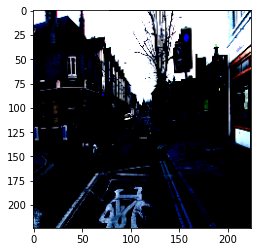

In [46]:
plt.imshow(ndimage.rotate(np.squeeze(inputs.numpy()).transpose(2,1,0), 270), cmap = 'gray')

In [47]:
inputs = inputs.to(device)
outputs = UNET(inputs)

In [48]:
outputs = outputs.cpu()
outputs = outputs.detach().numpy()
outputs = outputs.argmax(axis = 1)

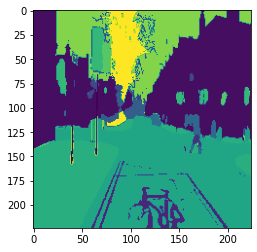

In [49]:
plt.imshow(outputs[0])